In [12]:
!pip install numpy scipy torch torchaudio librosa soundfile
!pip install speechbrain

Taking Real-time Input

In [13]:
from IPython.display import display, Javascript, Audio
from google.colab import output

In [14]:
def toggle_recording():
    js_code = """
    let recording = false;
    let recorder;
    let chunks = [];

    function startRecording() {
        navigator.mediaDevices.getUserMedia({ audio: true })
            .then(function(stream) {
                recorder = new MediaRecorder(stream);
                recorder.ondataavailable = function(event) {
                    chunks.push(event.data);
                };

                recorder.onstop = function() {
                    let blob = new Blob(chunks, { type: 'audio/wav' });
                    let reader = new FileReader();
                    reader.onload = function() {
                        const base64Audio = reader.result.split(',')[1];
                        google.colab.kernel.invokeFunction('notebook.save_audio', [base64Audio], {});
                    };
                    reader.readAsDataURL(blob);
                };

                recorder.start();
                console.log("Recording started...");
                document.getElementById("toggle-button").innerText = "Stop Recording";
            })
            .catch(function(err) {
                console.log("Error: " + err);
            });
    }

    function stopRecording() {
        recorder.stop();
        console.log("Recording stopped...");
        document.getElementById("toggle-button").innerText = "Start Recording";
    }

    function toggleRecording() {
        if (!recording) {
            startRecording();
        } else {
            stopRecording();
        }
        recording = !recording;
    }

    const button = document.createElement("button");
    button.id = "toggle-button";
    button.innerText = "Start Recording";
    button.onclick = toggleRecording;

    document.body.appendChild(button);
    """
    display(Javascript(js_code))


In [15]:
def save_audio(base64_audio):
    import base64
    audio_data = base64.b64decode(base64_audio)

    with open('/content/recorded_audio.wav', 'wb') as f:
        f.write(audio_data)

    print("Audio saved successfully.")

In [17]:
output.register_callback('notebook.save_audio', save_audio)
toggle_recording()

<IPython.core.display.Javascript object>

Audio saved successfully.


In [33]:
import torchaudio

waveform, sample_rate = torchaudio.load("recorded_audio.wav")
duration = waveform.shape[1] / sample_rate
print(f"Recorded audio duration: {duration} seconds")

Recorded audio duration: 14.94 seconds


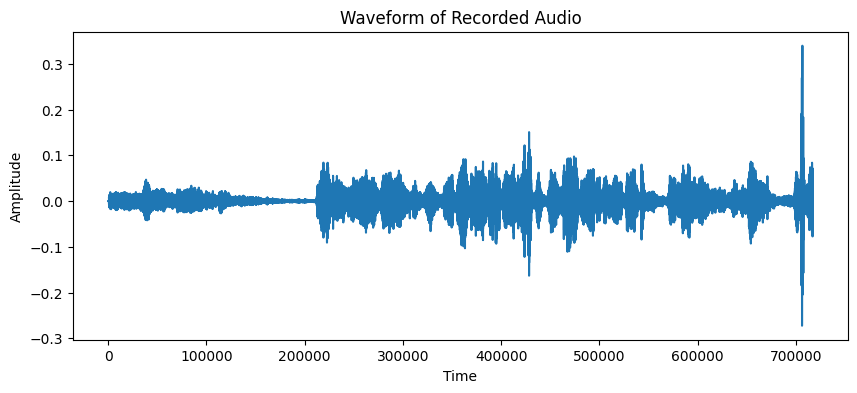

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(waveform[0].numpy())
plt.title("Waveform of Recorded Audio")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [35]:
import torchaudio.transforms as T

if sample_rate != 16000:
    resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
    waveform = resampler(waveform)
    torchaudio.save("recorded_audio_resampled.wav", waveform, 16000)

In [36]:
import torchaudio
import torch

In [37]:
from speechbrain.inference.separation import SepformerSeparation as separator
model1 = separator.from_hparams(
    source="speechbrain/sepformer-wham16k-enhancement",
    savedir='pretrained_models/sepformer-wham16k-enhancement')
audio_sources1 = model1.separate_file(path='/content/recorded_audio.wav')
if len(audio_sources1[0].shape) == 1:
    enhanced_waveform1 = audio_sources1[:,:,0].unsqueeze(0)  # Add channel dimension
else:
    enhanced_waveform1 = audio_sources1[:,:,0]  # Already 2D
enhanced_waveform1 = enhanced_waveform1 / enhanced_waveform1.abs().max()
torchaudio.save("converted_audio1.wav", enhanced_waveform1, 16000)

Resampling the audio from 48000 Hz to 16000 Hz


In [45]:
from speechbrain.inference.enhancement import SpectralMaskEnhancement
model2 = SpectralMaskEnhancement.from_hparams(
    source="speechbrain/metricgan-plus-voicebank",
    savedir="pretrained_models/metricgan-plus"
)
num_samples = waveform.shape[-1]
lengths = torch.tensor([num_samples / num_samples], dtype=torch.float32)
enhanced_waveform2 = model2.enhance_batch(waveform, lengths = lengths).squeeze(0)
enhanced_waveform2 = enhanced_waveform2 / enhanced_waveform2.abs().max()
enhanced_waveform2 = enhanced_waveform2.unsqueeze(0)

torchaudio.save("converted_audio2.wav", enhanced_waveform2, 16000)

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

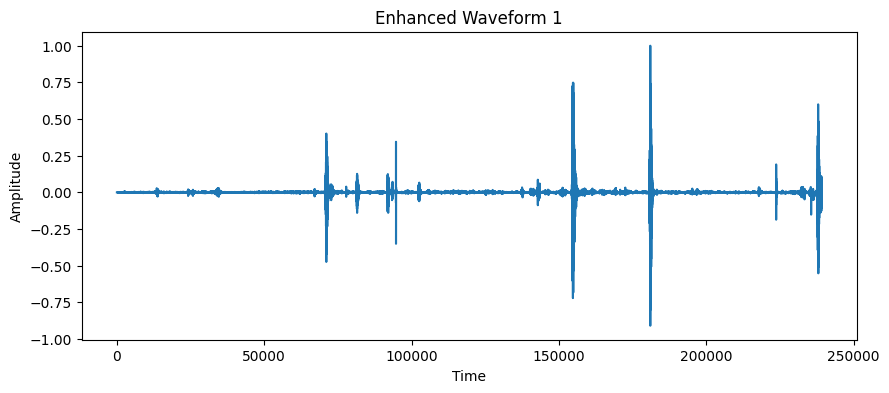

In [46]:
plt.figure(figsize=(10, 4))
plt.plot(enhanced_waveform1[0].numpy())
plt.title("Enhanced Waveform 1")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

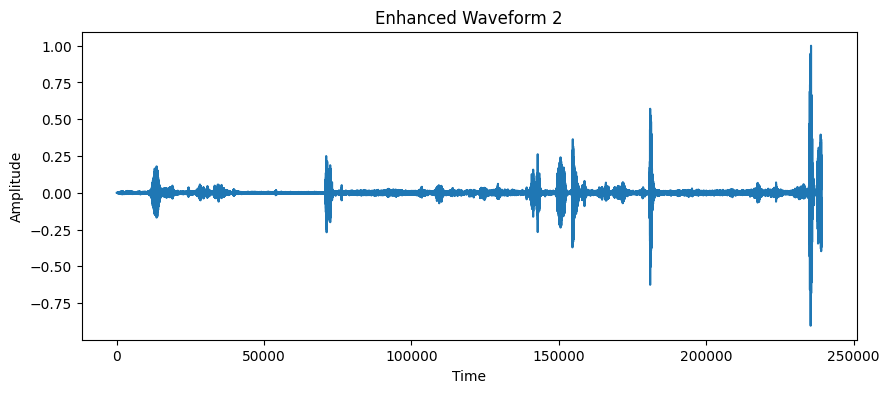

In [47]:
plt.figure(figsize=(10, 4))
plt.plot(enhanced_waveform2[0].numpy())
plt.title("Enhanced Waveform 2")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

<ipython-input-48-1a38b0089324>:4: UserWarning: PySoundFile failed. Trying audioread instead.
  recorded_audio, sr_recorded = librosa.load('/content/recorded_audio.wav', sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


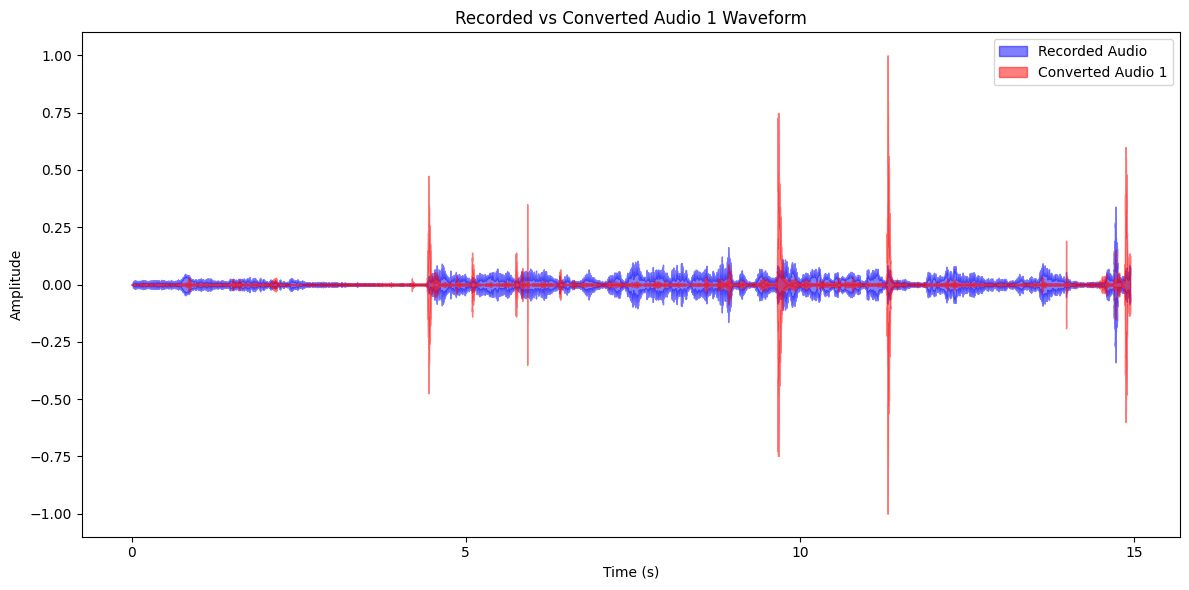

In [48]:
import librosa
import librosa.display

recorded_audio, sr_recorded = librosa.load('/content/recorded_audio.wav', sr=None)
converted_audio1, sr_converted1 = librosa.load('converted_audio1.wav', sr=None)

plt.figure(figsize=(12, 6))

librosa.display.waveshow(recorded_audio, sr=sr_recorded, color='b', alpha=0.5, label='Recorded Audio')

librosa.display.waveshow(converted_audio1, sr=sr_converted1, color='r', alpha=0.5, label='Converted Audio 1')

plt.title("Recorded vs Converted Audio 1 Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

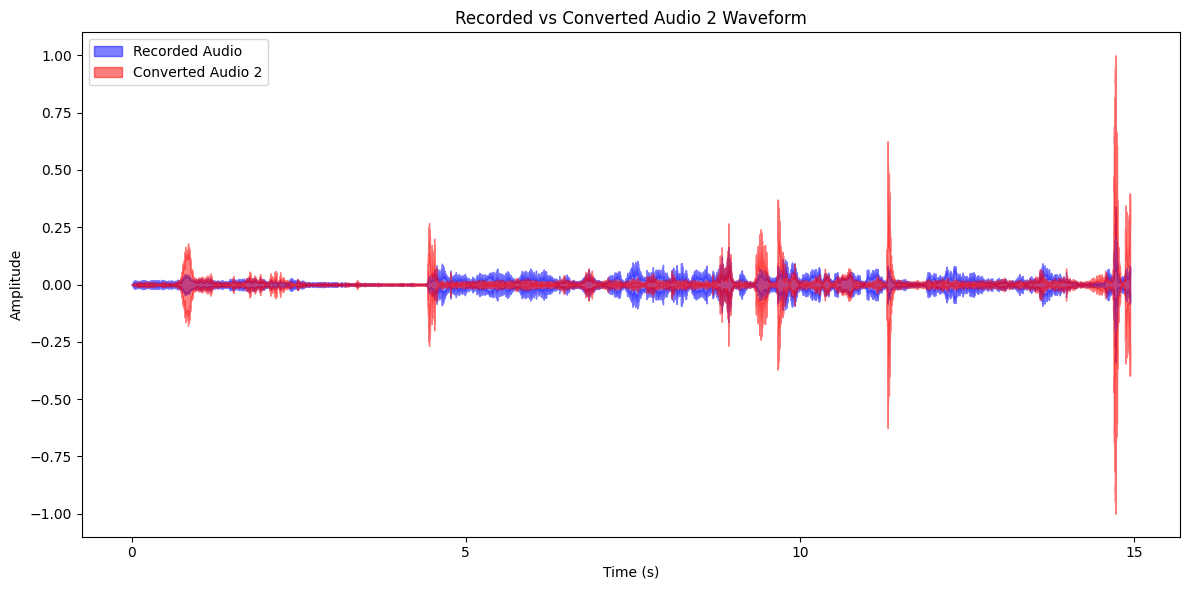

In [49]:
converted_audio2, sr_converted2 = librosa.load('converted_audio2.wav', sr=None)

plt.figure(figsize=(12, 6))

librosa.display.waveshow(recorded_audio, sr=sr_recorded, color='b', alpha=0.5, label='Recorded Audio')

librosa.display.waveshow(converted_audio2, sr=sr_converted2, color='r', alpha=0.5, label='Converted Audio 2')

plt.title("Recorded vs Converted Audio 2 Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()